In [114]:
import json
import matplotlib.pyplot as plt
from DBAASP.peptide import Peptide
import numpy as np
import pandas as pd
import torch
from qmap.toolkit import aligner
from qmap.toolkit.clustering import leiden_community_detection
import pickle
from pyutils import progress
import igraph as ig

In [3]:
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a list of tuples containing sequence IDs and sequences.
    :param file_path: The path to the FASTA file.
    :return:
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    sequences = []
    for line in lines:
        if line.startswith('>'):
            id_ = line[1:].strip()
        else:
            sequence = line.strip()
            sequences.append((id_, sequence))
    return sequences

In [21]:
with open('.cache/DBAASP_raw.json', 'r') as f:
    DBAASP = [Peptide(sample).sequence for sample in json.load(f) if Peptide(sample).complexity == "Monomer" and Peptide.sequence is not None]
    DBAASP = [seq for seq in DBAASP if len(seq) < 100]

PepAtlas = [sample[1] for sample in read_fasta("../peptide_atlas/.cache/peptide_atlas.fasta")]

In [23]:
encoder = aligner.Encoder()
DBAASP_enc = encoder.encode(DBAASP)

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  45/45 it 1.11 it/s eta 00:00


In [24]:
# 1h to run
PepAtlas_enc = encoder.encode(PepAtlas)

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━  6975/6975 it 1.33 it/s eta 00:00


In [28]:
# Save the embeddings
with open('.cache/DBAASP_enc.pkl', 'wb') as f:
    pickle.dump(DBAASP_enc, f)
with open('.cache/PepAtlas_enc.pkl', 'wb') as f:
    pickle.dump(PepAtlas_enc, f)

In [116]:
indexes = np.arange(len(PepAtlas_enc))
np.random.shuffle(indexes)
pep_atlas_enc = PepAtlas_enc.embeddings[indexes[:len(DBAASP_enc)]]
all_emb = torch.cat((DBAASP_enc.embeddings, pep_atlas_enc), dim=0)
activation = encoder.activation.to(DBAASP_enc.embeddings.dtype)
with open(".cache/DBAASPxPepAtlas.edgelist", 'w') as f:
    for i, vec in progress(all_emb).enum():
        neighbors = activation(vec @ all_emb.T) > 0.6
        for j in np.where(neighbors)[0]:
            f.write(f"{i} {j}\n")

 100%|█████████████████████████████████|  46022/46022 [00:30<00:00, 1253.13it/s] 


In [117]:
labels = np.concatenate((np.zeros(len(DBAASP_enc)), np.ones(len(pep_atlas_enc))))
g = ig.Graph.Read_Edgelist(".cache/DBAASPxPepAtlas.edgelist", directed=False)

In [118]:
clusters = leiden_community_detection(g, n_iterations=-1)

In [119]:
clusters["label"] = clusters["node_id"].apply(lambda x: labels[x])

In [139]:
communities = []
impurities = []
for community in clusters["community"].unique():
    sub = clusters[clusters["community"] == community]
    counts = sub["label"].value_counts()
    pepa = counts.get(1, 0)
    dbaasp = counts.get(0, 0)
    total = pepa + dbaasp
    communities.append(community)
    impurities.append(1 - (pepa / total)**2 - (dbaasp / total)**2)
    if len(sub) < 32:
        break
impurities = np.array(impurities)
communities = np.array(communities)

In [140]:
impurities

array([0.0010995 , 0.01724008, 0.        , 0.        , 0.02370029,
       0.        , 0.00332225, 0.03727468, 0.11337148, 0.07201448,
       0.00549446, 0.04875   , 0.03020437, 0.        , 0.02919067,
       0.29968158, 0.01526627, 0.24648367, 0.        , 0.        ,
       0.04935107, 0.01687641, 0.        , 0.        , 0.19830198,
       0.04403052, 0.00952359, 0.33345306, 0.3346875 , 0.01290268,
       0.0984989 , 0.        , 0.        , 0.01459775, 0.        ,
       0.01550293, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03844675, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.2055165 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3132716 , 0.        , 0.        , 0.     

In [141]:
idx = np.argsort(-impurities)
communities = communities[idx]
impurities = impurities[idx]

In [142]:
len(communities)

81

In [143]:
np.unique(impurities, return_counts=True)

(array([0.        , 0.0010995 , 0.00332225, 0.00549446, 0.00952359,
        0.01290268, 0.01459775, 0.01526627, 0.01550293, 0.01687641,
        0.01724008, 0.02370029, 0.02919067, 0.03020437, 0.03727468,
        0.03844675, 0.04403052, 0.04875   , 0.04935107, 0.05876951,
        0.07201448, 0.0984989 , 0.11337148, 0.19830198, 0.2055165 ,
        0.24648367, 0.29968158, 0.3132716 , 0.33345306, 0.3346875 ]),
 array([52,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]))

(array([65.,  6.,  2.,  1.,  0.,  1.,  1.,  1.,  1.,  3.]),
 array([0.        , 0.03346875, 0.0669375 , 0.10040625, 0.133875  ,
        0.16734375, 0.2008125 , 0.23428125, 0.26775   , 0.30121875,
        0.3346875 ]),
 <BarContainer object of 10 artists>)

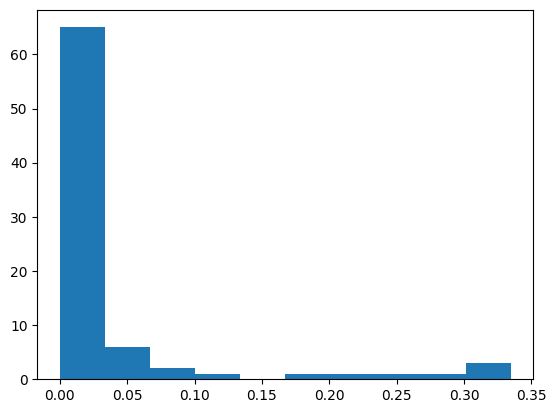

In [144]:
plt.hist(impurities)

In [112]:
sub = clusters[clusters["community"] == 80]
sub

,node_id,community,label
433,1157,80,0.0
434,39769,80,1.0


In [81]:
np.unique(labels, return_counts=True)

(array([0., 1.]), array([  23011, 3570953]))

label
1.0    3570837
0.0      23011
Name: count, dtype: int64